In [ ]:
!pip3 install pmdarima
!pip3 install seaborn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from pmdarima.arima import auto_arima
import pmdarima as pm
import multiprocessing as mp
import pickle 

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [5]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [ ]:
## Trying to fit ARMA models on the training data

target_sensors = df1.columns.tolist()
target_sensors.remove("DATETIME")
target_sensors.remove("ATT_FLAG")
models = []

def get_arima(sensor, series):
    print("Currently trying to fit " + sensor)
    stepwise_fit = auto_arima(series, start_p=1, start_q=1, max_p=50, max_q=50,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
    return (sensor, stepwise_fit)

pool = mp.Pool(processes=4)
models = [pool.apply_async(get_arima, args=(sensor, df1[sensor].values.copy(),)) for sensor in target_sensors]
pool.close()  # do not accept any more tasks
pool.join()  # wait for the completion of all scheduled jobs

In [ ]:
## Saving these models
models_to_write = [model.get() for model in models]
filename = "ARMA_models.obj"
file_to_write = open(filename, 'wb')
pickle.dump(models_to_write, file_to_write)

In [6]:
## Load again and check the best fits
filename = "ARMA_models.obj"

file_to_read = open(filename, 'rb')
models_read = pickle.load(file_to_read)

In [8]:
## Check the top ARMA models
aic_models = pd.DataFrame(columns=['AIC', 'order', 'params'])
for model in models_read:
    aic_models.loc[model[0], :]= np.array([model[1].aic(), model[1].order, model[1].params()])

target_models = aic_models.sort_values(by='AIC').head(11)[1:]
target_models

,AIC,order,params
P_J280,-78191.2,"(4, 0, 6)","[0.42863868876775624, 0.8253129266190251, 0.27..."
S_PU11,-48586.6,"(0, 0, 1)","[0.00045151544263363, 0.9996531541558552, 0.00..."
S_PU6,-34533.1,"(0, 0, 2)","[0.0018204245232758198, 0.7518657647955579, 0...."
L_T1,-13301.2,"(2, 0, 3)","[0.09138378526719937, 1.8316204855026392, -0.8..."
L_T6,-12699,"(7, 0, 3)","[3.9139003653793587, 0.5811814226462853, -0.11..."
L_T3,-7863.57,"(2, 0, 4)","[1.1204248195566007, 1.7152234731765925, -0.98..."
S_PU2,-4219.97,"(2, 0, 8)","[0.019105302138679073, 1.876948729544768, -0.9..."
L_T2,-1101.28,"(4, 0, 3)","[0.05504329327469419, 3.4903826780266844, -4.8..."
L_T5,-689.113,"(5, 0, 5)","[2.2762646438082688, 1.011293448630082, -0.325..."
S_V2,-175.315,"(3, 0, 7)","[0.6043142303568986, 0.3744087948402374, -0.10..."


In [10]:
## Saving the target_model parameters
filename = "target_models.obj"
file_to_write = open(filename, 'wb')
pickle.dump(target_models, file_to_write)

In [12]:
## Loading the target_model parameters
filename = "target_models.obj"
file_to_read = open(filename, 'rb')
target_models = pickle.load(file_to_read)

In [13]:
source_df = df1
target_df = df2

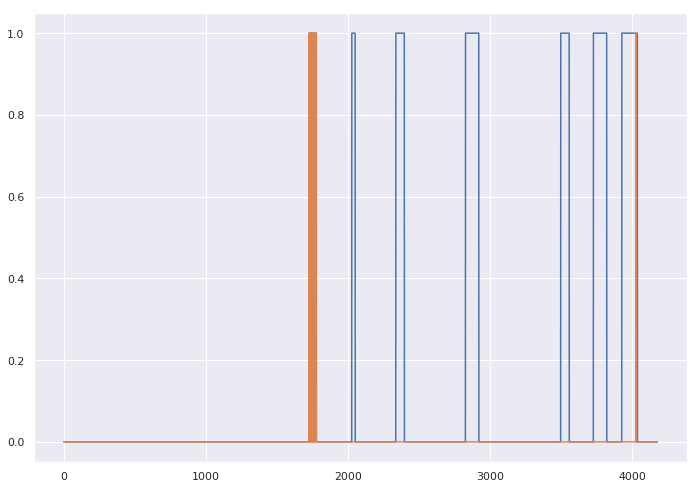

In [14]:
## Find some correlation with attacks and signals

fig, ax = plt.subplots()
target = 'S_PU11'
attack = target_df['ATT_FLAG'].copy()
sns.lineplot(data=attack,ax=ax)
sns.lineplot(data=target_df[target],ax=ax)

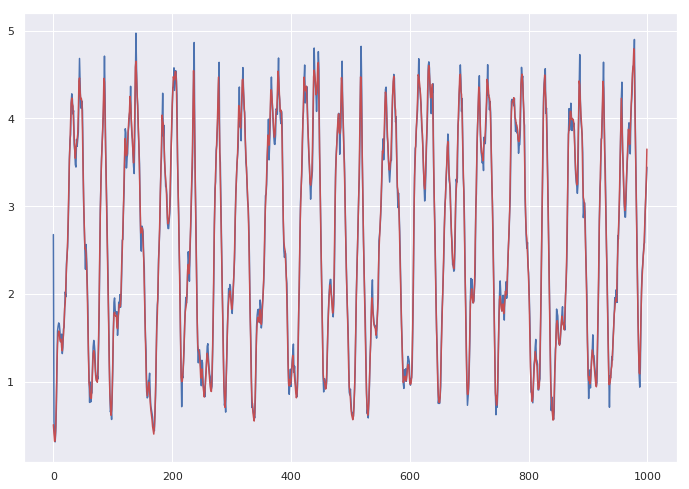

In [17]:
## Show example predictions
current_model = None
target = 'L_T1'
for model in models_read:
    if model[0] == target:
        current_model = model
        break
predictions = current_model[1].predict_in_sample()
true_data = source_df[target]

fig, ax = plt.subplots()
sns.lineplot(data=predictions[0:1000], ax=ax, color='b')
sns.lineplot(data=true_data[0:1000], ax=ax, color='r')

In [18]:
## Set a threshold for anomalies and see if there are any

min_diff = min(abs(predictions - true_data))
max_diff = max(abs(predictions - true_data))
max_diff =0.5
steps = 50

ranges = np.arange(min_diff,max_diff, (max_diff-min_diff)/steps)
rates = pd.DataFrame([], index=ranges, columns=["True Positive",'False Negative'])


for threshold in ranges:
    rates.loc[threshold, 'True Positive'] = (target_df.loc[abs(predictions - true_data) > threshold, ['ATT_FLAG']] == 1).sum()[0]
    rates.loc[threshold, 'False Negative'] = (target_df.loc[abs(predictions - true_data) > threshold, ['ATT_FLAG']] == 0).sum()[0]
    
recall = rates['True Positive'] /  rates['True Positive'].max()
precision = rates['True Positive'] /  (rates['True Positive'] + rates['False Negative'])


[Text(0.5, 0, 'Threshold')]

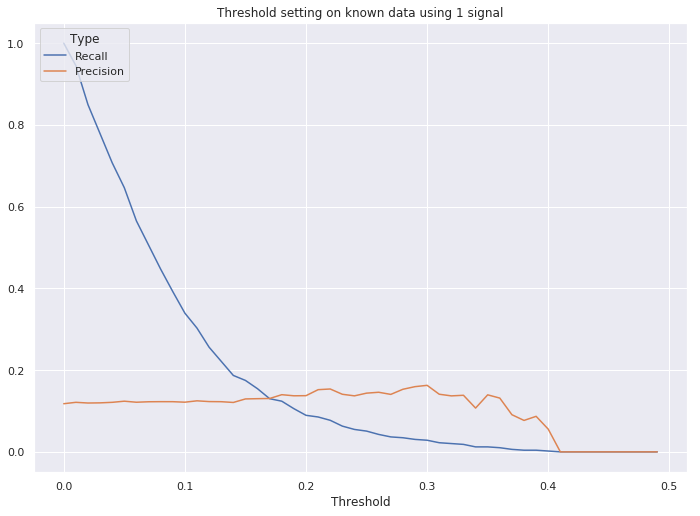

In [19]:
fig, ax = plt.subplots()
sns.lineplot(data=recall, ax=ax)
sns.lineplot(data=precision, ax=ax)
ax.legend(title='Type', loc='upper left', labels=['Recall', 'Precision'])
ax.legend(title='Type', loc='upper left', labels=['Recall', 'Precision'])
ax.set(title="Threshold setting on known data using 1 signal")
ax.set(xlabel='Threshold')

In [ ]:
## Copying the known values for the top models:
source_df = df1
target_df = df2

which_columns = target_models.index.values

warmup = 100

window_width = 100
data_streams =  source_df.loc[len(source_df):,which_columns].reset_index(drop=True)
params = target_models['params']

trained_models = []

predictions = pd.DataFrame(columns=which_columns)

for i in range(0, len(target_df), window_width): 
    ## Create the new models
    data_streams = data_streams.append(target_df.loc[i:i+window_width-1, which_columns],ignore_index=True)
    trained_models = []
    
    new_predictions = pd.DataFrame(columns=which_columns)
    
    if i < warmup:
        continue
        
    for column in which_columns:
        try:
            trained_model = pm.ARIMA(order=target_models.loc[column, 'order'], seasonal_order=(0,0,0,1), start_params=params[column], suppress_warnings=True)
        except:
            trained_model = pm.ARIMA(order=target_models.loc[column, 'order'], seasonal_order=(0,0,0,1), suppress_warnings=True)
        trained_model.fit(data_streams[column])
        trained_models.append(trained_model)
        new_predictions[column] = trained_model.predict(window_width)
        
    new_predictions.index = range(i+window_width,i+window_width+window_width)
    predictions = predictions.append(new_predictions)

In [ ]:
fig, ax = plt.subplots()
data_streams = data_streams.append(target_df.loc[i:i+window_width-1, which_columns],ignore_index=True)

sns.lineplot(data=data_streams[column], ax=ax)
sns.lineplot(data=predictions[column], ax=ax)

In [ ]:
target_models

In [ ]:
trained_model